# Digital Down Conversion

This notebook walks through the usage of a two key modules for one-bit radio:

- **OneBitFixedOscillator** - This generates a 1-bit sine wave, deseralized into a specified word length (usually 20) that is mixed with an incoming signal
- **SummingMixer** - This mixes an incoming deserialized 1-bit signal with I and Q oscillators at a specified carrier frequency and decimates by 4 (via a simple running sum)

To get started, let's first import the components we'll need

In [1]:
%matplotlib inline
import numpy as np
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from alldigitalradio.oscillator import OneBitFixedOscillator
from alldigitalradio.io.numpy import make_callable, take_n
from alldigitalradio.util import pack_mem, unpack_mem, make_carrier, binarize
from alldigitalradio.shiftregisters import prbs9
from alldigitalradio.mixer import SummingMixer

# The One-Bit Oscillator

First, let's look at the one bit oscillator, which outputs an approximate "sine" wave quantized to one bit.

Because we're going to mix this with a 5gbps (or greater) signal, we need to parallelize and thus the oscillator is designed to output the wave deserialized into a specified width. Both Lattice and Xilinx SERDES implementations support 20-bit words so we'll default to this. To demonstrate that there's more precision here than meets the eye, we'll generate a signal from two oscillators slightly offset in frequency and plot the FFT.

Goal Frequency: 2402250000.0, actual: 2402250000.0, period: 20000, len: 1000
Goal Frequency: 2401750000.0, actual: 2401750000.0, period: 20000, len: 1000


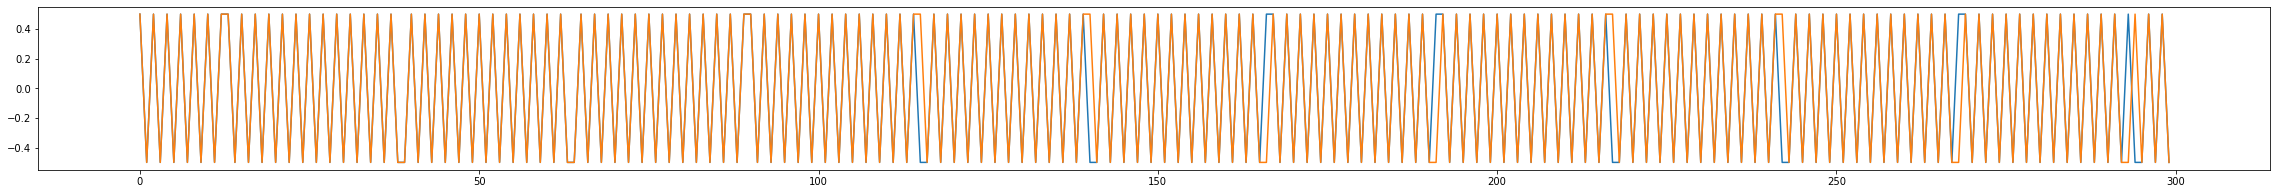

In [2]:
freq = 2.402e9
sample_rate = 5e9
error = 0.0001
count = 2048

# The oscillator takes a couple cycles for the pipelines to be fully initialized
osc1 = make_callable(OneBitFixedOscillator(sample_rate=sample_rate, frequency=freq + 250e3, max_error=error, width=20), startup_cycles=2)
# Unpack things from 20-bit words to single bits and remove the DC offset
sample1 = unpack_mem(take_n(osc1, count), 20) - 0.5

# Do the same for a slightly different signal
osc2 = make_callable(OneBitFixedOscillator(sample_rate=sample_rate, frequency=freq - 250e3, max_error=error, width=20), startup_cycles=2)
sample2 = unpack_mem(take_n(osc2, count), 20) - 0.5

# Now draw out these "sine waves" so we can visually inspect how different they are
plt.figure(figsize=(40,3))
plt.plot(sample1[:300])
plt.plot(sample2[:300])

<ipython-input-3-0015e9cb975f>:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(fftbins, 10*np.log10(abs(fft2)/np.max(np.abs(fft2))))


(-20.0, 5.0)

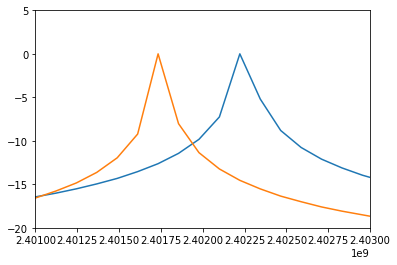

In [3]:
# Plot the FFTs of each signal
fft1 = fft(sample1)
fft2 = fft(sample2)
fftbins = fftfreq(len(sample1), 1/sample_rate)

# Use dB for the Y axis
plt.plot(fftbins, 10*np.log10(abs(fft1)/np.max(np.abs(fft1))))
plt.plot(fftbins, 10*np.log10(abs(fft2)/np.max(np.abs(fft2))))

plt.gca().set_xlim(freq - 1e6, freq + 1e6)
plt.gca().set_ylim(-20, 5)

# The One-Bit Mixer
Next, let's demonstrate using these one-bit oscillators with a one-bit mixer to downconvert a signal into baseband I and Q samples. First, let's make a quick modulated signal at 2.402ghz. For simplicity, we'll do BPSK.

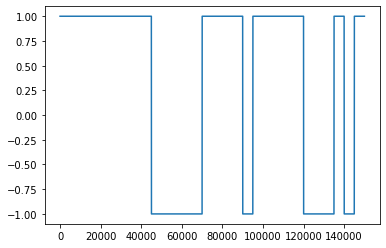

In [30]:
baseband = prbs9()[:30]
symbol_rate = 1e6
samples_per_symbol = int(sample_rate/symbol_rate)

# Stretch out the baseband signal to the sample rate we'll "transmit" at and also convert it to "phase"
baseband = np.repeat(baseband, samples_per_symbol)*2.0 - 1.0
plt.plot(baseband)

# Make the carrier with a slight phase offset to demonstrate the effectiveness of both I and Q channels
carrier = make_carrier(freq=2.402e9, sample_rate=5e9, samples=len(baseband), phase=np.pi/6)

# Convert this to a binary signal
modulated = binarize(carrier*baseband)

Just to make sure it's obvious that the modulated signal is one bit, here's the first few hundred samples

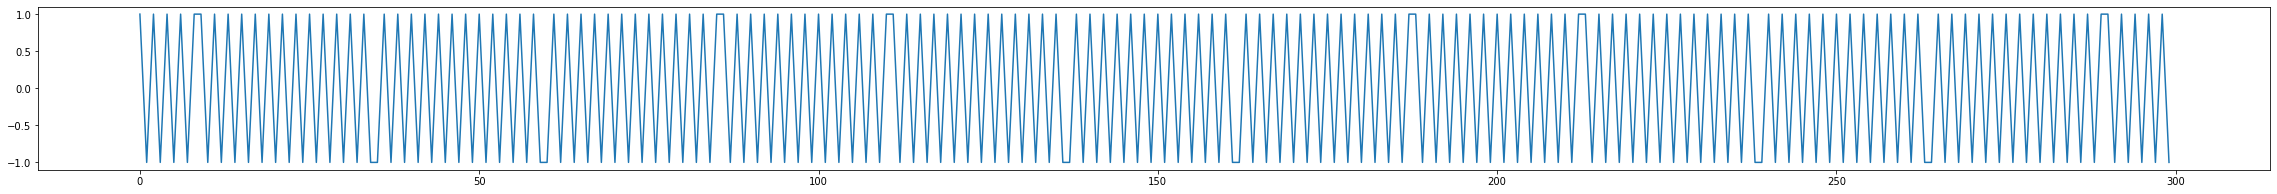

In [5]:
plt.figure(figsize=(40,3))
plt.plot(modulated[:300])

Alright, let's now use our summing mixer to demodulate this 1-bit data

Goal Frequency: 2402000000.0, actual: 2402000000.0, period: 2500, len: 125
Goal Frequency: 2402000000.0, actual: 2402000000.0, period: 2500, len: 125


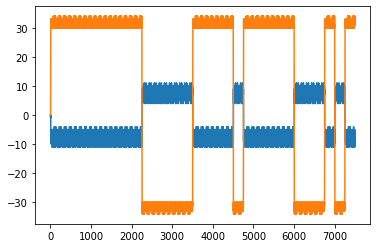

In [20]:
# Pack the one bit data into 20 bit words
packed_modulated = pack_mem(modulated*0.5 + 0.5, 20)

# The mixer itself instantiates the oscillator
mixer = make_callable(SummingMixer(sample_rate=5e9, frequency=2.402e9, max_error=0.0001), startup_cycles=4)

out = np.array(list(map(mixer, packed_modulated)))

plt.plot(out[:,0])
plt.plot(out[:,1])

That looks like our data!

It's further afferming to plot a constellation plot (which is just each estimated I and Q value plotted as a dot on a 2D coordinate plane).

(-40.0, 40.0)

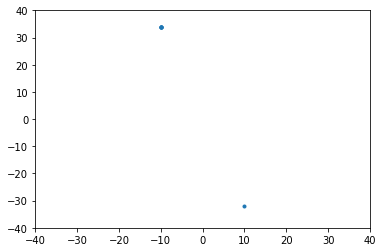

In [36]:
# Sample the I&Q values in the middle of each symbol, note that the mixer
# downconverts and sums by 4, which is why we take every samples_per_symbol//4 rather
# than just every samples_per_symbol
sampled_i = out[samples_per_symbol//8::samples_per_symbol//4,0]
sampled_q = out[samples_per_symbol//8::samples_per_symbol//4,1]

plt.plot(sampled_i, sampled_q, '.')
plt.gca().set_xlim(-40, 40)
plt.gca().set_ylim(-40, 40)

The thing we can see here is that this is rotated by pi/6 or 30 degrees, which is expected because our test signal was modulated against a carrer with a 30 degree phase shift.